<a href="https://colab.research.google.com/github/beezow526/midoribon/blob/main/Chapter11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap11/input/Y.csv

In [1]:

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import binom
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

%matplotlib inline
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:

#Git上からデータをインポート

import urllib.request
from io import StringIO

url ="https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap11/input/Y.csv"

#csvを読み込む関数
def read_csv(url):
    print(url)
    res = urllib.request.urlopen(url)
    res = res.read().decode("utf-8")
    df = pd.read_csv(StringIO(res))
    return df

df = read_csv(url)
df = df.drop("Unnamed: 0", axis=1)
 

https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap11/input/Y.csv


In [7]:
ｄｆ.head()

,x
0,0
1,3
2,2
3,5
4,6


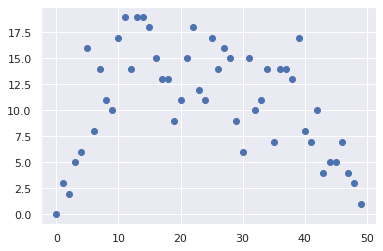

In [10]:
plt.scatter(df.index,df["x"])

In [11]:
print(df["x"].mean())
print(df["x"].var())

10.88
27.373061224489792


#  階層ベイズモデルに空間構造を組み込む
観測データ{$y_j$}に基づいて、位置によって変化する局所密度を構成できるような統計モデルを作る

$$
p(y_j | \lambda) = \frac {\lambda^{y_j} exp(-\lambda)} {y_j!}
$$

In [30]:
#model

#Stanに辞書型でデータを引き渡す
ps_data = {
    "N_site":50,
    "Y":df["x"]
}

#pystan用のコードを用いて,y=β０　+　rのモデルを定義
model = """
data {
  int<lower=1>N_site; #サンプルサイズ
  int<lower=0>Y[N_site]; #個体数
}

parameters {
   real beta;
   real r[N_site];
   real<lower=0> s_r;
}

model {
  for (j in 2:N_site){
    r[j] ~ normal(r[j-1],s_r); 
  }
  for (j in 1:N_site){
    Y[j] ~ poisson_log(beta + r[j]);
  }
}  

generated quantities{
  real <lower=0> Y_mean[N_site];
  for(j in 1:N_site){
    Y_mean[j] <-exp(r[j]);
  }
}

"""

In [31]:
import pystan as ps

stmodel2 = ps.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dede183ecfc5714a7b6b6af5a6eb084b NOW.


In [33]:
# MCMCサンプリングのステップ数
n_iter = 1500

# MCMCサンプリングの反復数の指定(WinBUGSではデフォルト3)
n_chains = 3

# MCMCサンプリングの最初の何ステップの結果を使わないとするか(burnin)
n_warmup = 100

# MCMCサンプリングのステップのうち、何個飛ばしでサンプリング結果を記録するか
n_thin = 1

# NUTSアルゴリズムを使ってサンプリングの実行
fit2 = stmodel2.sampling(
    data=ps_data,
    iter=n_iter,
    chains=n_chains,
    n_jobs=1,
    warmup=n_warmup,
    algorithm="NUTS",
    thin=n_thin,
    seed=0)

print(fit2)

Inference for Stan model: anon_model_dede183ecfc5714a7b6b6af5a6eb084b.
3 chains, each with iter=1500; warmup=100; thin=1; 
post-warmup draws per chain=1400, total post-warmup draws=4200.

             mean se_mean     sd    2.5%     25%      50%    75%  97.5%  n_eff   Rhat
beta        30.18   45.86  64.15  -72.21  -20.63     27.8   78.6 148.92      2    3.7
r[1]       -29.14   45.87  64.17  -147.8  -78.12   -26.74  21.74  73.39      2    3.7
r[2]       -28.98   45.87  64.16  -147.7  -77.73   -26.55  21.89  73.73      2    3.7
r[3]       -28.81   45.86  64.16  -147.5  -77.48   -26.44  22.06  73.72      2    3.7
r[4]       -28.54   45.86  64.16  -147.2  -77.24   -26.12  22.36   73.9      2    3.7
r[5]       -28.24   45.85  64.15  -146.9  -76.85   -25.83  22.63  74.11      2    3.7
r[6]       -27.89   45.86  64.15  -146.6  -76.53   -25.43  22.98  74.55      2    3.7
r[7]       -27.88   45.86  64.16  -146.6  -76.45   -25.46  22.95  74.66      2    3.7
r[8]       -27.74   45.86  64.16  -146

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ce02177d0>,
      dtype=object)

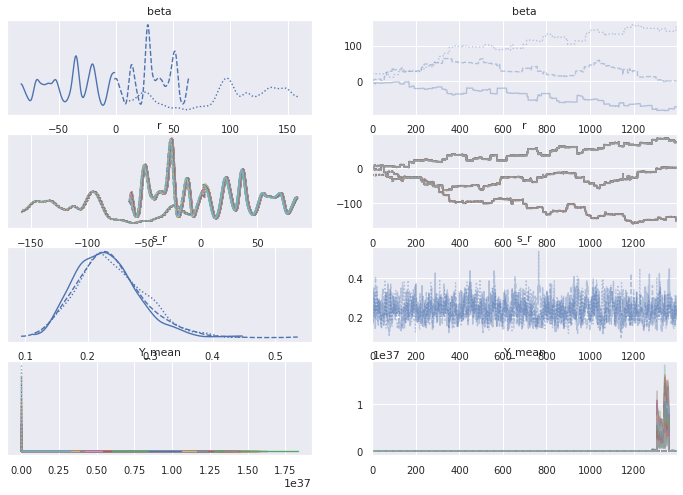

In [34]:

import arviz as az

az.plot_trace(fit2)